#Temas de conversacion sobre los campos de opiniones.


Hacer un análisis de los campos donde la gente deja su opinión sobre su estancia, y ver qué temas aparecen y cómo se representan. 

Tenemos disponibles :
Access, 
Description, 
Host about, 
House Rules,
Interaction,
NeighborhoodOverview
Space,
Summary.

In [9]:
#Instalacion librerias necesarias

!pip install gensim
!pip install pyLDAvis
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm
!pip install stop_words

# Librerías
import gensim
from os.path import join
import csv
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io
import es_core_news_sm

import warnings
warnings.filterwarnings('ignore')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Debido a que hay registros en español y en ingles, obtentemos la lista de stop-words en ambos idiomas

In [0]:
# Obtenemos una lista de 'stop words', palabras como artículos o adverbios que no son topics, en inglés
stop_words1 = get_stop_words('en') + list(punctuation) + [' ']
stop_words1_signos = [ '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
nlp1 = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner', 'textcat'])

In [0]:
# Obtenemos una lista de 'stop words', palabras como artículos o adverbios que no son topics, en español
stop_words2 = get_stop_words('es') + list(punctuation) + [' ']
nlp2 = es_core_news_sm.load()

In [12]:
# Librerías y funciones necesarias
import numpy as np 
import pandas as pd
import openpyxl

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split

# Conecta con google drive
from google.colab import drive
drive.mount('/content/drive')

# Carga del dataset de pisos de airbnb Madrid filtrado (13258 reg) sólo por la ciudad Madrid.
airbnbMadrid = pd.read_csv('/content/drive/My Drive/airbnblistingsMadridv1.csv', sep=';', decimal='.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Búsqueda de Topics en la categoría "Host About"

In [0]:
# Reduce dataset a la variable objetivo : 
airbnbMadridObj = airbnbMadrid['Host About']

In [14]:
airbnbMadridObj.head(5)

0                                                  NaN
1                                                  NaN
2    Hi! \r\r\n\r\r\nI travel a lot - for work and ...
3    I am from Spain but I have lived abroad for ma...
4                                                  NaN
Name: Host About, dtype: object

In [15]:
# Se calcula el número de nulos
print(f'El dataframe tiene un total de {len(airbnbMadridObj)} filas.')
print((f'Número de nulos : '),len(airbnbMadridObj) - airbnbMadridObj.count())

El dataframe tiene un total de 13258 filas.
Número de nulos :  4996


In [0]:
# Eliminacion de nulos y abreviatura del dataframe
df = airbnbMadridObj.fillna(' ')

In [0]:
# Se sustituyen los puntos por espacios. Si hay nulos,se sustituyen por espacios
for i in range(len(df)+1):
    try:
      df[i] = df[i].replace("."," ")
    except:
      df[i] = ' ' 

In [0]:
# Se eliminan las comas por espacios. Si hay nulos,se sustituyen por espacios
for i in range(len(df)+1):
    try:
      df[i] = df[i].replace(","," ")
    except:
      df[i] = ' '

In [0]:
# Filtramos los stop_words
documents = [] 

for q in df:                               # para cada registro del dataframe
    p = ""
    q = q.lower()                          # ponemos todas las letras en minúsculas

    for doc in (q.split(' ')):             # para cada palabra del registro
      if doc not in stop_words1 :          # filtra las stop words en ingles
         if doc not in stop_words2 :       # filtra las stop words en español
            p = p+doc+(' ')                # construimos un registro filtrado
    q=p

    r = ""                                
    for doc1 in q :                        # de nuevo, para cada palabra del registro ya filtrado
      if doc1 not in stop_words1_signos :  # filtramos los signos, no importa el idioma
         r = r+doc1                        # construimos un registro filtrado
    q=r

    q1 = [t.text for t in nlp1(q.rstrip(), disable=['parser', 'tagger', 'ner'])]
    q2 = [t.text for t in nlp2(q.rstrip(), disable=['parser', 'tagger', 'ner'])]
    documents.append(q1) # junta todo en un mismo corpus
    documents.append(q2) # junta todo en un mismo corpus

In [20]:
vocab = set([t for doc in documents for t in doc]) # conjunto de palabras(con lo que las palabras serán únicas)
w2id = {k:i for  i,k in enumerate(vocab)}          # crea un diccionario de las palabras de vocab 
id2w = {i:k for k, i in w2id.items()}              # lo convierte en tokens
print('{} unique tokens'.format(len(w2id)))        #  muestra el número de tokens únicos

17456 unique tokens


In [0]:
# Gensim es una biblioteca de código abierto para el modelado de temas no supervisados ​​y el procesamiento del 
# lenguaje natural, que utiliza el aprendizaje automático moderno de estadística.
from gensim.corpora import Dictionary

In [22]:
#Crea un diccionario con las palabras extraídas
gensim_dict = Dictionary(documents)
len(gensim_dict) # número de elementos del diccionario

17456

In [0]:
# corpus : colección de documentos
# doc2bow crea una bolsa de palabras (una lista con un núm id de la palabra y el número de veces que aparece)
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

Implementación usando Gensim. Buscaremos el modelo con el número óptimo de topics y nos quedaremos con el que más coherencia nos dé.

In [0]:
#build a model
from gensim import corpora, models, similarities

# Buscaremos el número de topics que más coherencia nos de
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

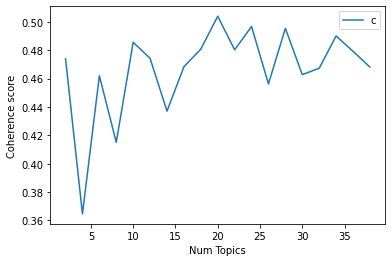

In [25]:
# Con un gráfico veremos más fácilmente
limit=40; start=2; step=2; # buscará topics de dos en dos, desde 2 hasta 40
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")           # eje x, número de topics
plt.ylabel("Coherence score")      # eje y, coherencia
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Buscamos el Máximo de coherencia y el num topicos adecuado
MaxCoherencia=max(coherence_values)
coherence_values.index(MaxCoherencia)
NumTopic=((coherence_values.index(MaxCoherencia)+1)*2)

print("Maxima coherencia : ", MaxCoherencia)
print("Num. Topics : ", NumTopic)

Maxima coherencia :  0.5038942199136758
Num. Topics :  20


In [27]:
# Modelo con mejor número de topics
# Entrena modelo LDA, pasándole el corpus y el diccionario calculado arriba.
# Se le pasa el NumTopic calculado arriba
lda_small = models.LdaModel(corpus, id2word=gensim_dict, num_topics=NumTopic, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(corpus))
vis = pyLDAvis.gensim.prepare(lda_small, corpus, gensim_dict)
pyLDAvis.display(vis)

# Si vamos a los topics, y marcamos sobre ellos, muestra los términos más relevantes de ése topic.
# Para analizar los temas que genera el algoritmo veamos uno a uno :
# Num1 : Se concentra en describir Madrid, y conocer people
# Num2 : Se habla mucho de musica y Madrid
# Num3 : Se piensa conocer gente y gusta viajar, y culturas del mundo


-5014520.075708985
